### En este script se incluyen las fases descriptiva y predictiva.

In [2]:
import numpy as np

def generar_datos_cuantitativos(elementos_dict, num_muestras=1000):
    """
    elementos_dict: {'H': perfil_picos_H, 'He': perfil_picos_He, ...}
    """
    X = [] # Espectros (Imágenes o vectores 1D)
    y = [] # Concentraciones (Las "respuestas" para la IA)

    for _ in range(num_muestras):
        # 1. Generar concentraciones aleatorias que sumen 1 (100%)
        # Esto es lo que la IA debe aprender a predecir
        concentraciones = np.random.dirichlet(np.ones(len(elementos_dict)), size=1)[0]
        
        # 2. Crear el espectro combinado
        espectro_total = np.zeros(longitud_onda_rango)
        
        for i, (nombre, perfil) in enumerate(elementos_dict.items()):
            # Multiplicamos el perfil físico por su concentración
            espectro_total += concentraciones[i] * perfil
            
        # 3. Añadir "Ruido de Laboratorio" (para que no sea perfecto)
        ruido = np.random.normal(0, 0.02, longitud_onda_rango)
        espectro_total += ruido
        
        X.append(espectro_total)
        y.append(concentraciones)
        
    return np.array(X), np.array(y)

# 1. Definimos el rango de longitud de onda (igual que en tu app)
longitud_onda_rango = 800 - 350  # 450 puntos si vas de 1 en 1 nm
x_wavelengths = np.linspace(350, 800, longitud_onda_rango)

# 2. Creamos los perfiles físicos (Firma de cada elemento)
# Aquí simulamos dónde están los picos principales
def crear_perfil(picos):
    perfil = np.zeros(longitud_onda_rango)
    for p in picos:
        # Usamos una gaussiana para dar forma al pico
        perfil += np.exp(-0.5 * ((x_wavelengths - p) / 2)**2)
    return perfil

# Firmas espectrales (esto es lo que pedirías a los expertos)
perfiles_dict = {
    "Hidrogeno": crear_perfil([434, 486, 656]),
    "Helio": crear_perfil([447, 501, 587, 667]),
    "Sodio": crear_perfil([589]),
    "Calcio": crear_perfil([393, 396, 422, 445])
}

# 3. LLAMADA A LA FUNCIÓN (Aquí es donde se genera el dataset)
print("Generando datos sintéticos para entrenamiento...")
X_train, y_train = generar_datos_cuantitativos(perfiles_dict, num_muestras=5000)

print(f"¡Listo! Dataset creado con {X_train.shape[0]} muestras.")
print(f"Forma de los datos (X): {X_train.shape} -> (Muestras, Puntos de onda)")
print(f"Forma de las etiquetas (y): {y_train.shape} -> (Muestras, Concentraciones)")

Generando datos sintéticos para entrenamiento...
¡Listo! Dataset creado con 5000 muestras.
Forma de los datos (X): (5000, 450) -> (Muestras, Puntos de onda)
Forma de las etiquetas (y): (5000, 4) -> (Muestras, Concentraciones)


1. Arquitectura de la Red (1D-CNN)

Esta estructura asume que tu espectro ha sido normalizado a un vector de tamaño fijo (por ejemplo, 1000 puntos de intensidad).

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

def crear_modelo_espectrometria(input_shape, num_elementos):
    model = models.Sequential([
        # --- EXTRACCIÓN DE CARACTERÍSTICAS ---
        # Primera capa conv: Detecta formas básicas de picos
        layers.Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        
        # Segunda capa conv: Detecta combinaciones de picos (patrones de elementos)
        layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        
        # Tercera capa conv: Patrones más complejos
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(), # Reduce el vector a sus características principales
        
        # --- CLASIFICACIÓN ---
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3), # Para evitar el sobreajuste (overfitting)
        
        # Capa de salida: Sigmoide para Clasificación Multi-etiqueta
        # (Permite detectar varios elementos al mismo tiempo)
        layers.Dense(num_elementos, activation='sigmoid') 
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # Ideal para multi-etiqueta
        metrics=['accuracy']
    )
    
    return model

# Ejemplo de uso:
# Si tu espectro tiene 1000 puntos y quieres detectar 10 elementos posibles:
# input_shape = (1000, 1) -> (longitud, canales)
modelo = crear_modelo_espectrometria((1000, 1), 10)
modelo.summary()

c:\Users\DEVELOPER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 994, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 497, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 493, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 246, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 244, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,066 (207.29 KB)

 Trainable params: 53,066 (207.29 KB)

 Non-trainable params: 0 (0.00 B)

2. ¿Por qué esta arquitectura?

    Conv1D (filtros): Imagina que el filtro es una pequeña ventana que se desliza sobre el espectro buscando la "forma" de un pico de Hidrógeno. Al tener varias capas, la red aprende primero a ver picos individuales y luego a reconocer "familias" de picos que definen a un elemento (como la serie de Balmer).

    GlobalAveragePooling1D: En lugar de "aplanar" todo (Flatten), esta capa promedia los mapas de características. Esto hace que el modelo sea más ligero y menos propenso a memorizar el ruido.

    Salida Sigmoide: En un problema de clasificación normal usamos Softmax (que elige solo uno), pero aquí usamos Sigmoid porque una sustancia puede ser una mezcla de Hierro, Carbono y Helio simultáneamente. Cada nodo de salida dará una probabilidad independiente (0 a 1) para cada elemento.

Como los picos en espectrometría no son líneas infinitesimales sino que tienen un ancho debido al principio de incertidumbre y efectos térmicos (Doppler broadening), los modelamos comúnmente con la Función Gaussiana.

Aquí tienes cómo construir un generador de datos sintéticos robusto:
1. Modelado Matemático de un Pico

Un pico en la longitud de onda λ0​ se define como:
I(λ)=A⋅exp(−2σ2(λ−λ0​)2​)

Donde A es la intensidad (amplitud) y σ controla el ancho del pico.
2. Generador de Espectros en Python

Este script genera un espectro que combina:

    Fondo de Cuerpo Negro (Usando una aproximación de la Ley de Planck).

    Picos de Emisión (Gaussianas).

    Ruido Blanco (Para que el ML aprenda a ignorarlo).

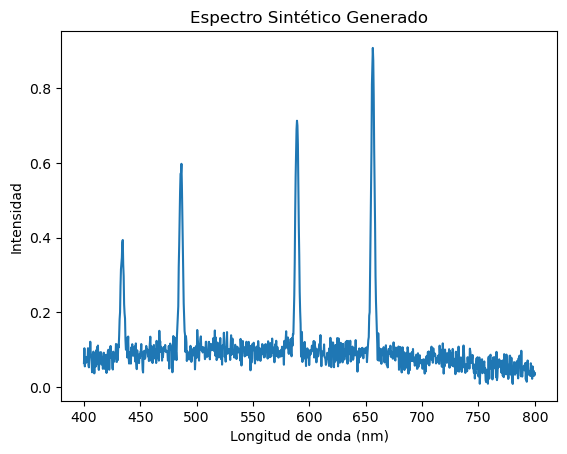

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generar_espectro_sintetico(longitudes_onda, elementos_presentes, ruido=0.02):
    """
    longitudes_onda: array de numpy (ej. de 400 a 700 nm)
    elementos_presentes: dict con {lambda_central: intensidad}
    """
    # 1. Fondo de Cuerpo Negro (Simulado con una curva suave)
    # En un caso real, usarías la fórmula de Planck con una T específica
    continuo = 0.1 * np.exp(-(longitudes_onda - 550)**2 / (2 * 200**2))
    
    espectro = continuo.copy()
    
    # 2. Agregar picos de los elementos
    for lam0, intensidad in elementos_presentes.items():
        sigma = 1.5  # Ancho del pico
        pico = intensidad * np.exp(-(longitudes_onda - lam0)**2 / (2 * sigma**2))
        espectro += pico
        
    # 3. Agregar Ruido Aleatorio
    espectro += np.random.normal(0, ruido, len(longitudes_onda))
    
    return np.clip(espectro, 0, 1) # Normalizar entre 0 y 1

# --- EJEMPLO DE USO ---
x = np.linspace(400, 800, 1000) # Rango visible en nm

# Simulamos una sustancia con Hidrógeno (líneas H-alpha, beta, etc.)
sustancia_x = {
    656.3: 0.8, # H-alpha
    486.1: 0.5, # H-beta
    434.0: 0.3, # H-gamma
    589.0: 0.6  # Un pico extra (ej. Sodio)
}

y = generar_espectro_sintetico(x, sustancia_x)

plt.plot(x, y)
plt.title("Espectro Sintético Generado")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Intensidad")
plt.show()

3. Estrategia para crear tu Dataset de Entrenamiento

Para que tu modelo de Machine Learning sea realmente potente, debes automatizar la creación de miles de estos ejemplos:

    Diccionario de Elementos: Crea un archivo JSON o una clase donde guardes las longitudes de onda características de cada elemento (H, He, Fe, etc.) según el NIST.

    Combinaciones Aleatorias:

        Crea una función que elija de 1 a 3 elementos al azar.

        Asigne intensidades aleatorias a cada uno.

        Genere el espectro y guarde el vector resultante (Input X) y un vector binario de etiquetas (Output Y).

    Variabilidad: Varía ligeramente el parámetro σ (ancho de banda) y el nivel de ruido en cada ejemplo para que el modelo aprenda a ser flexible.

¿Cuál es el siguiente paso lógico?

Podemos hacer una de estas dos cosas:

    Crear el script de entrenamiento masivo: Generar 10,000 espectros y guardarlos en un formato que la red neuronal que diseñamos antes pueda leer.

    Refinar el Simulador Streamlit: Hacer que el simulador permita al usuario "mezclar" elementos en tiempo real con sliders y ver cómo cambia el espectro antes de pasarlo por el modelo.

Vamos a dividirlo en dos grandes fases. Empecemos con el Script de Entrenamiento Masivo.
Fase 1: Script de Entrenamiento (Data Gen + Model Training)

Este script hará tres cosas: generará miles de muestras, las etiquetará y entrenará la red neuronal que definimos antes.
1. Definición de la "Base de Datos" Química

Primero, definimos las líneas espectrales (longitudes de onda en nm) para los elementos que queremos que el modelo reconozca.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib # Para guardar etiquetas

# Diccionario de elementos y sus líneas principales (simplificado)
ELEMENT_DB = {
    "Hidrogeno": [656.3, 486.1, 434.0, 410.2],
    "Helio": [587.6, 667.8, 501.5, 447.1],
    "Sodio": [589.0, 589.6],
    "Calcio": [422.7, 393.4, 396.8]
}

ELEMENTOS = list(ELEMENT_DB.keys())
NUM_ELEMENTOS = len(ELEMENTOS)
X_RANGE = np.linspace(350, 800, 1000) # De UV cercano a IR cercano

def generar_dataset(n_muestras=5000):
    X = []
    y = []
    
    for _ in range(n_muestras):
        espectro = np.zeros_like(X_RANGE)
        etiquetas = np.zeros(NUM_ELEMENTOS)
        
        # Elegir de 1 a 3 elementos presentes al azar
        n_presents = np.random.randint(1, 4)
        indices_presents = np.random.choice(range(NUM_ELEMENTOS), n_presents, replace=False)
        
        for idx in indices_presents:
            nombre = ELEMENTOS[idx]
            etiquetas[idx] = 1 # One-hot encoding multietiqueta
            intensidad_base = np.random.uniform(0.3, 1.0)
            
            # Agregar todas las líneas del elemento
            for linea in ELEMENT_DB[nombre]:
                # Pequeña variación en la posición por efecto Doppler/Ruido
                pos = linea + np.random.normal(0, 0.2)
                sigma = np.random.uniform(1.0, 2.0)
                pico = intensidad_base * np.exp(-(X_RANGE - pos)**2 / (2 * sigma**2))
                espectro += pico
        
        # Agregar ruido de fondo (Cuerpo Negro / Continuo)
        espectro += 0.05 * np.random.random(len(X_RANGE)) 
        
        # Normalizar espectro total
        if espectro.max() > 0:
            espectro /= espectro.max()
            
        X.append(espectro)
        y.append(etiquetas)
        
    return np.array(X).reshape(-1, 1000, 1), np.array(y)

# 2. Generar y Entrenar
print("Generando datos...")
X_train, y_train = generar_dataset(8000)

# Reutilizamos la arquitectura 1D-CNN que definimos antes
# (Asegúrate de tener la función crear_modelo_espectrometria definida arriba)
model = crear_modelo_espectrometria((1000, 1), NUM_ELEMENTOS)

print("Entrenando modelo...")
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# 3. Exportar para Streamlit
model.save('modelo_espectrometria.h5')
joblib.dump(ELEMENTOS, 'etiquetas_elementos.pkl')
print("¡Modelo guardado!")

Generando datos...
Entrenando modelo...
Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4134 - loss: 0.5976 - val_accuracy: 0.4425 - val_loss: 0.5322
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4494 - loss: 0.5083 - val_accuracy: 0.5144 - val_loss: 0.4793
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4683 - loss: 0.4830 - val_accuracy: 0.5263 - val_loss: 0.4624
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4900 - loss: 0.4690 - val_accuracy: 0.5437 - val_loss: 0.4448
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5053 - loss: 0.4557 - val_accuracy: 0.5500 - val_loss: 0.4316
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5117 - loss: 0.4443 - val_accuracy: 0.5344 - val_loss: 0.4169
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5216 - loss: 0.4403 - val_accuracy: 0.5481 - val_loss: 0.4091
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - ac

¡Modelo guardado!
